In [1]:
import dill
import numpy as np
import scanner_interpretation as sc
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from corner import corner
import astropy.visualization as vis
rd = sc.Reduced("pkl_jugs/n4/reduced_complete.pkl")
rd_old = sc.Reduced("pkl_jugs/n3/reduced_complete.pkl")
# rd_old.reduced["BERNOULLI_SIGMA"] = sc.n_sigmas(rd_old.reduced["BERNOULLI_P"])


def get_leftover(redu) -> np.ndarray:

# pval_0_mask = redu.reduced["LAMBDA_RATIO_SIGNIFICANCE"]==0.
    bernP_nan_mask = np.isnan(redu.reduced["BERNOULLI_P"])
    expP_nan_mask = np.isnan(redu.reduced["EXP_CORRECTED_P"])
    bernP_finite_mask = np.isfinite(redu.reduced["BERNOULLI_P"])
    expP_finite_mask = np.isfinite(redu.reduced["EXP_CORRECTED_P"])
    bernP_0_mask = redu.reduced["BERNOULLI_P"] == 0
    expP_0_mask = redu.reduced["EXP_CORRECTED_P"] == 0

    sanebern = ~bernP_nan_mask * bernP_finite_mask * ~bernP_0_mask
    saneexp = ~expP_nan_mask * expP_finite_mask * ~expP_0_mask

    leftover = sanebern * saneexp
    return leftover

l_n4 = get_leftover(rd)
l_n3 = get_leftover(rd_old)

Flux

In [2]:
rd.addFlux()
rd_old.addFlux()

100%|██████████| 26329/26329 [00:00<00:00, 161799.43it/s]


In [4]:
from astropy.table import Table
from scipy.stats import spearmanr,pearsonr

def get_correlation(tab: Table,var_names:list[str],corrfn = pearsonr):
    if len(var_names) != 2:
        raise ValueError(f"Please give 2 variables instead of {len(var_names)}")
    return corrfn(tab[var_names[0]],tab[var_names[1]])


In [5]:
get_correlation(rd.reduced[l_n4],["FLUX_ERGS_PER_SECOND_CM2","BERNOULLI_SIGMA"],spearmanr)

SpearmanrResult(correlation=0.36519562820466606, pvalue=1.8712435170541127e-118)

In [7]:
rd.reduced["LOG_FLUX_ERGS_PER_SECOND_CM2"] = np.log10(rd.reduced["FLUX_ERGS_PER_SECOND_CM2"])

Pandas support in corner is deprecated; use ArviZ directly


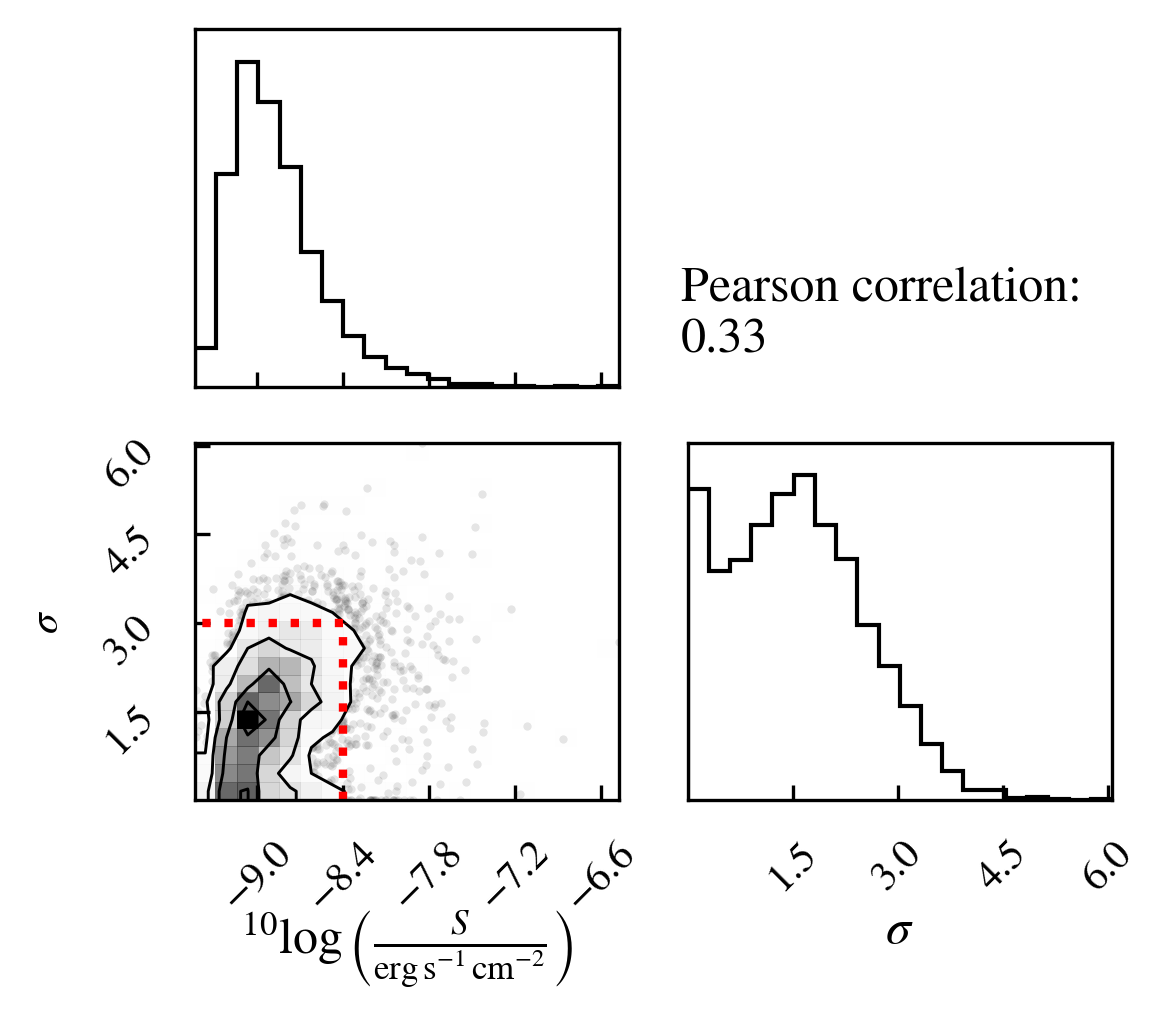

In [49]:
from matplotlib import figure,axes
fig: figure.Figure = corner(rd.reduced[l_n4].to_pandas(),var_names=["LOG_FLUX_ERGS_PER_SECOND_CM2","BERNOULLI_SIGMA"],labels=[r"$^{10}\log\left(\frac{S}{\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}}\right)$",r"$\sigma$"])
axs: list[axes.Axes] = fig.get_axes()
for i,ax in enumerate(axs):
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(True)
    # ax.set_title(i)
    ax.set_xlabel(ax.get_xlabel(),fontsize="large")
# axes[0].set_yscale("log")
axs[2].vlines(-8.4,0,3,color="red",ls=":",lw=2)
axs[2].hlines(3,-10,-8.4,color="red",ls=":",lw=2)
# axs[2].text(-8,2,"Short Burst Flux limit\nfor H.E.S.S.?")
fig.set_size_inches(4,3.5)
fig.text(.58,.65,f"Pearson correlation:\n{np.round(get_correlation(rd.reduced[l_n4],var_names=['LOG_FLUX_ERGS_PER_SECOND_CM2','BERNOULLI_SIGMA'])[0],2)}",fontsize="large")
fig.savefig("figures/flux_sigma_corner.png",facecolor='white',dpi=300)

## Candidates
Luminosity

In [54]:
def luminosity(flux:float, distance_cm: float) -> float:
    return flux * 4 * np.pi * distance_cm **2

print("galactica nd extragalactic luminosity estimates in ergs per second of the 35007 mplet")
for d in [3e22, 3e24 *  2863]: #10kpc galactic, 0.5z = 2863 Mpc xgal
    print(luminosity(rd.getCandidate(35007)["FLUX_ERGS_PER_SECOND_CM2"].data,d))

galactica nd extragalactic luminosity estimates in ergs per second of the 35007 mplet
[4.48837525e+37]
[3.67901751e+48]


In [59]:
cand = rd.getCandidate(35007)[0]
toa_bkg = [180828547.77256322, 180828950.41976643, 180829178.5714972, 180829669.495579,180829828.01819682]
toa_sgl = [180829669.5254898, 180829669.78794956, 180829670.10159612]
from scipy.stats import expon
from math import factorial
rate_bkg = 1.0/expon.fit(np.diff(toa_bkg),floc=0.)[1]
rate_sgl = 1.0 / expon.fit(np.diff(toa_sgl),floc=0)[1]

L = 3 * rate_bkg / rate_sgl
sum = 1
for i in range(3):
    sum -= L**i * np.exp(-L) / factorial(i)

p_succes = sum / cand["BELL_FRACTION"]
sign = (1.-(1.-p_succes)**(23490))
print(sc.n_sigmas(sign))
print(cand["BERNOULLI_SIGMA"])


1.691796529001013
4.316950259487835


In [109]:
cd = rd.getCandidate(35007)
cd = sc.Candidate(cd[cd["BERNOULLI_SIGMA"] > 4])
from matplotlib import figure,axes
obj = cd.ToAScatter(0.1)
fig: figure.Figure = obj[0]
ax: axes.Axes = obj[1]
fig.set_size_inches(3.2,2)
ax.set_xlabel("ToA within run [a.u.]")
ax.set_xticks([])
ax.ticklabel_format(style="sci",axis="x",useOffset=False)
ax.fill_between(np.linspace(1.8082964*1e8,1.808297*1e8),.025,.07,color="red",alpha=.5,zorder=3)
ax.fill_between(np.linspace(1.8082964*1e8,1.808297*1e8),.025,.105,color="orange",alpha=.4,zorder=3)
fig.text(.55,.4,"Triplet",color="darkred")
fig.text(.55,.3,"Quadruplet",color="darkorange")
ax.set_ylim(0,.11)
ax.set_yticks([0,.05,.1])
ax.set_ylabel(r"$d(\mathrm{phot},\mathrm{mplet})$ [deg]")
fig.savefig("figures/ToA_35007.png",facecolor="white",dpi=300)

row is a Table of length 1, not a row. Taking first!
hess1


In [ ]:
sixplets = rd.reduced[rd.reduced["Nmax"] == 6]
sixplets.sort("dt")
sixplets

In [ ]:
cd.mplet["dt"] / 1e6

In [ ]:
significant_table = rd.reduced[rd.reduced["BERNOULLI_SIGMA"] > 5]
significant_table.sort("BERNOULLI_SIGMA")
significant_table

In [ ]:
rd_old.getCandidate(35007)

In [ ]:
plt.figure()
plt.yscale("log")
h = plt.hist(rd.reduced[l_n4]["BERNOULLI_SIGMA"],histtype="step",color="m",bins="fd",label="$da = 0.4$",density=True)
h2 = plt.hist(rd_old.reduced[l_n3]["BERNOULLI_SIGMA"],histtype="step",color="c",bins="fd",label="$da = 0.2$",density=True)
plt.legend()
plt.xlabel("sigma")


In [ ]:
for var,label in zip(["PNT_DISTANCE","ALT_PNT"],[r"$d(\mathrm{mplet}, PNT)$ [deg]",r"Pointing altitude [deg]"]):
    pearson, spearman = pearsonr(rd.reduced[l_n4]["BERNOULLI_SIGMA"].data,rd.reduced[l_n4][var].data)[0],spearmanr(rd.reduced[l_n4]["BERNOULLI_SIGMA"].data,rd.reduced[l_n4][var].data)[0]
    fig = corner(rd.reduced[l_n4].to_pandas(),var_names=[var,"BERNOULLI_SIGMA"],labels=[label,r"$\sigma$"])
    fig.text(.55,.7,f"Pearson correlation: {np.round(pearson,2)}\nSpearman rank correlation: {round(spearman,2)}",fontsize="large")
    fig.set_size_inches(4,4)
    for ax in fig.get_axes():
        ax.spines["right"].set_visible(True)
        ax.spines["top"].set_visible(True)
    plt.savefig("figures/combined/pnt-significance-correlation.png",facecolor="white",dpi=300)